In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional
from torch.utils.data import random_split
from torch.utils.data import DataLoader

import torchvision as tv
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import ResNet34_Weights
import torch.nn.functional as F
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt

In [3]:
train_data_tensor = torch.load('./data_tensor.pth')
train_labels_tensor = torch.load('./labels_tensor.pth')
val_data_tensor = torch.load('./val_data_tensor.pth')
val_labels_tensor = torch.load('./val_labels_tensor.pth')

In [4]:
train_dataset, val_dataset = [], []
for i in range(len(train_labels_tensor)):
    train_dataset.append((train_data_tensor[i], train_labels_tensor[i]))

for i in range(len(val_labels_tensor)):
    val_dataset.append((val_data_tensor[i], val_labels_tensor[i]))

In [5]:
torch.manual_seed(42)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [7]:
resnet34 = models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

In [26]:
out_features1 = 128

class RESNET34(nn.Module):
    def __init__(self):
        super(RESNET34, self).__init__()
        # remove fully connected layer at the end
        self.resnet = nn.Sequential(*list(resnet34.children())[:-1])
        
        self.fc1 = nn.Linear(resnet34.fc.in_features, out_features1)
        self.fc2 = nn.Linear(out_features1, 30)

        self.batchnorm1 = nn.BatchNorm1d(out_features1)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        
        # Forward pass through your fully connected layers
        x = F.relu(self.batchnorm1(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [25]:
# get the accuracy of the model prediction and the actual value
def get_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in dataloader:
            model.eval()
            if torch.backends.mps.is_built():
                imgs = imgs.to("mps")
                labels = labels.to("mps")
            # get the output using resnet
            output = model(imgs)

            # select index with maximum prediction
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total += imgs.shape[0]
    
    return correct / total

In [32]:
# train the model using alex net
def train(model, data, batch_size, num_epochs, learning_rate, momentum, verbose=False):
    # use cross entropy loss function and SGD with momentum
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    iters, epochs, losses, train_acc, val_acc = [], [], [], [], []


    n = 0
    for epoch in range(num_epochs):
        mini_b = 0
        mini_batch_correct = 0
        mini_batch_total = 0
        print("epoch: {}".format(epoch))

        for imgs, labels in iter(data):
            if torch.backends.mps.is_built():
                imgs = imgs.to("mps")
                labels = labels.to("mps")
            # calculate loss
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # find the loss and accuracy
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            mini_batch_total = imgs.shape[0]
            train_acc.append(mini_batch_correct / mini_batch_total)
            iters.append(n)
            losses.append(float(loss) / batch_size)
            n += 1
            mini_b += 1
            
            if verbose and n % 10 == 0:
                print("Iteration: {} Training Accuracy: {} Loss: {}".format(n, train_acc[-1], losses[-1]))
        scheduler.step()
        # print the accuracy
        val_acc.append(get_accuracy(model, val_loader))
        epochs.append(epoch)
        print("Training Accuracy = {}".format(train_acc[-1]))
        print("Validation Accuracy = {}".format(val_acc[-1]))

    # plot the loss curve
    plt.title("Loss Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    # plot the training and validation curve
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    # plot the training and validation curve
    plt.title("Validation Curve")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

epoch: 0
Iteration: 10 Training Accuracy: 0.09375 Loss: 0.0535014346241951
Iteration: 20 Training Accuracy: 0.21875 Loss: 0.047055259346961975
Iteration: 30 Training Accuracy: 0.234375 Loss: 0.04458767548203468
Iteration: 40 Training Accuracy: 0.34375 Loss: 0.04215949401259422
Iteration: 50 Training Accuracy: 0.453125 Loss: 0.03816995024681091
Iteration: 60 Training Accuracy: 0.375 Loss: 0.035341955721378326
Iteration: 70 Training Accuracy: 0.40625 Loss: 0.034861285239458084
Iteration: 80 Training Accuracy: 0.515625 Loss: 0.03184034302830696
Iteration: 90 Training Accuracy: 0.515625 Loss: 0.029309816658496857
Iteration: 100 Training Accuracy: 0.453125 Loss: 0.030030999332666397
Iteration: 110 Training Accuracy: 0.53125 Loss: 0.027475297451019287
Iteration: 120 Training Accuracy: 0.625 Loss: 0.022004393860697746
Iteration: 130 Training Accuracy: 0.546875 Loss: 0.02673172578215599
Iteration: 140 Training Accuracy: 0.546875 Loss: 0.025653496384620667
Iteration: 150 Training Accuracy: 0.65

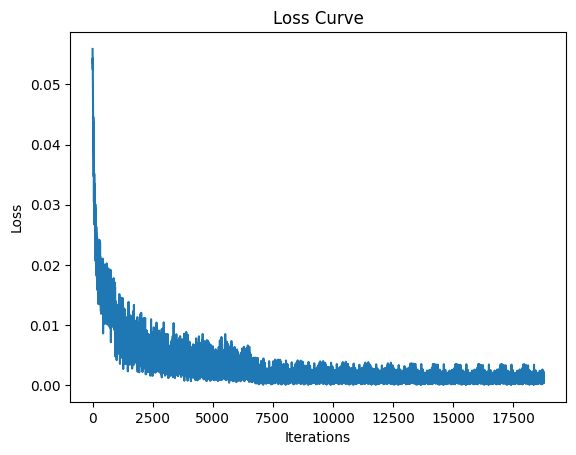

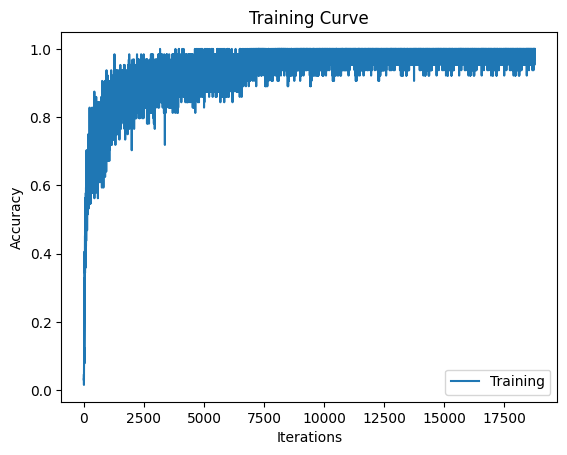

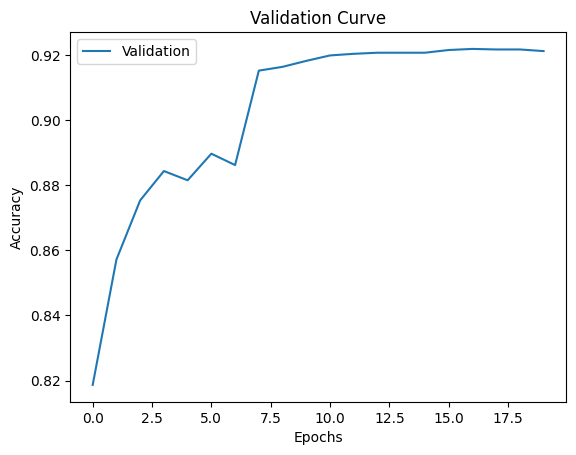

TypeError: get_accuracy() got an unexpected keyword argument 'train'

In [30]:
# use resnet 
model = RESNET34()
# freeze parameters
for param in model.resnet.parameters():
    param.requires_grad = False

# hyperparameters
num_epochs = 20
learning_rate = 0.01
momentum = 0.9
batch_size = 64

if torch.backends.mps.is_built():
    model.to("mps")

train(model=model, data=train_loader, batch_size=batch_size, num_epochs=num_epochs, learning_rate=learning_rate, momentum=momentum, verbose=True)

torch.save(model, 'full_resnet34_1_1.pth')


# unfreeze parameters
for param in model.resnet.parameters():
    param.requires_grad = True

# hyperparameters
num_epochs = 20
learning_rate = 0.0001
momentum = 0.9
batch_size = 64

if torch.backends.mps.is_built():
    model.to("mps")

train(model=model, data=train_loader, batch_size=batch_size, num_epochs=num_epochs, learning_rate=learning_rate, momentum=momentum, verbose=True)

torch.save(model, 'full_resnet34_1_2.pth')

model.cpu()

In [33]:
model = torch.load("full_resnet34_1_1.pth")

# unfreeze parameters
for param in model.resnet.parameters():
    param.requires_grad = True

# hyperparameters
num_epochs = 5
learning_rate = 0.0001
momentum = 0.9
batch_size = 64

if torch.backends.mps.is_built():
    model.to("mps")

train(model=model, data=train_loader, batch_size=batch_size, num_epochs=num_epochs, learning_rate=learning_rate, momentum=momentum, verbose=True)

torch.save(model, 'full_resnet34_1_2.pth')

FileNotFoundError: [Errno 2] No such file or directory: 'full_resnet34_1_1.pth'

In [36]:
# get_accuracy(model, train_loader)
get_accuracy(model, val_loader)

RuntimeError: Input type (MPSFloatType) and weight type (torch.FloatTensor) should be the same

In [31]:
model.cpu()

RESNET34(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)